# Simple Invariant and Equivariant Networks

Author: Roy Forestano

Date: 1 June 2023

Based on ideas from:
- E(n) Equivariant Graph Neural Networks: https://arxiv.org/abs/2102.09844


- What is an equivariant neural network?: https://arxiv.org/abs/2205.07362
- Equivariant Architectures for Learning in Deep Weight Spaces: https://arxiv.org/abs/2301.12780
- Invariant and Equivariant Graph Networks: https://arxiv.org/abs/1812.09902
- On the Universality of Invariant Networks: https://arxiv.org/abs/1901.09342
- Provably Powerful Graph Networks: https://arxiv.org/abs/1905.11136
- An Introduction To Invariant Graph Networks: http://irregulardeep.org/An-introduction-to-Invariant-Graph-Networks-(1-2)/
- Lorentz Group Equivariant Autoencoders: https://indico.cern.ch/event/1256618/
- Geometric Deep Learning and Equivariant Neural Networks: https://arxiv.org/abs/2105.13926
- A General Theory of Equivariant CNNs on Homogeneous Spaces: https://arxiv.org/abs/1811.02017
- Geometrical aspects of lattice gauge equivariant convolutional neural networks: https://arxiv.org/abs/2303.11448
- Equivariant Architectures for Learning in Deep Weight Spaces: https://arxiv.org/abs/2301.12780
- Equivariance: https://dmol.pub/dl/data.html#running-this-notebook

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import scipy
import os
import copy
from tqdm import tqdm
from time import time
import itertools

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
torch.set_default_dtype(torch.float64)
plt.rcParams["font.family"] = 'sans-serif'
np.set_printoptions(formatter={'float_kind':'{:f}'.format}) 

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Make Squares and Triangles

In [2]:
# make_rectangle = np.array([[0.1,0.9],
#                            [0.9,0.9],
#                            [0.1,0.1],
#                            [0.9,0.1]]).reshape(4,2)

# make_triangle = np.array([[0.5,0.9],
#                           [0.5,0.45],
#                           [0.1,0.1],
#                           [0.9,0.1]]).reshape(4,2)

In [2]:
s=0.
l=1.
dsize = 30
np.random.seed(0)
make_rectangle = np.hstack([ np.random.uniform(s,l, dsize).reshape(dsize,1), np.random.uniform(s, l, dsize).reshape(dsize,1)]).reshape(dsize,2)

np.random.seed(1)
middle =0.5
new1_rectangle = np.hstack([ np.random.uniform(s,middle, dsize).reshape(dsize,1), np.random.uniform(s, l, dsize).reshape(dsize,1)]).reshape(dsize,2)
new2_rectangle = np.hstack([ np.random.uniform(middle,l, dsize).reshape(dsize,1), np.random.uniform(s, l, dsize).reshape(dsize,1)]).reshape(dsize,2)
make_triangle = np.zeros((dsize,2))
found = 0
for i in range(dsize):
    if found<dsize:
        if (new1_rectangle[i,1]-2*new1_rectangle[i,0])<0:
            make_triangle[found] =copy.deepcopy(new1_rectangle[i])
            found+=1
    if found<dsize:
        if (new2_rectangle[i,1]-2+2*new2_rectangle[i,0])<0:
            make_triangle[found] =copy.deepcopy(new2_rectangle[i])
            found+=1
print(found)

if make_rectangle.shape[0]>found:
    print('Dropping Extra Indices Shapes')
    make_rectangle = copy.deepcopy(make_rectangle)[:found,:]
    make_triangle = copy.deepcopy(make_triangle)[:found,:]

25
Dropping Extra Indices Shapes


In [3]:
make_rectangle.shape

(25, 2)

In [4]:
make_triangle.shape

(25, 2)

In [5]:
# new1_rectangle

In [6]:
np.max(np.random.uniform(s, l, dsize))

0.9695957483196745

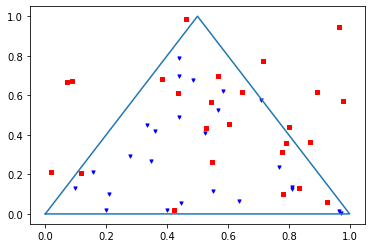

In [7]:
plt.scatter(make_rectangle[:,0],make_rectangle[:,1],c='r',s=20,marker='s')
plt.scatter(make_triangle[:,0],make_triangle[:,1],c='b',s=10,marker='v')
plt.plot([0.,0.5,1.0,0.0],[0.,1.0,0.,0.])

In [8]:
np.random.seed(0)
translations = np.random.uniform(low=-5,high=5,size=10)

def rot_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],
                     [np.sin(theta),np.cos(theta)]]).reshape(2,2)

angles = np.linspace(start=0,stop=2*np.pi,num=10)
rotations = [rot_matrix(angle) for angle in angles]

In [9]:
rotations[1]

array([[0.766044, -0.642788],
       [0.642788, 0.766044]])

In [10]:
#rotations[1]@make_rectangle.transpose()

In [11]:
new_square = rotations[1]@make_rectangle.transpose()

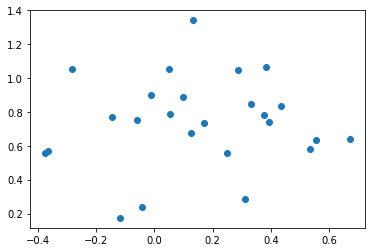

In [12]:
plt.scatter(new_square[0,:],new_square[1,:])

In [13]:
np.random.seed(0)
squares  = [  [(rotation@(make_rectangle+np.random.uniform(low=0,high=0.5,size=(found,2))).transpose()+translation).transpose(),0] for rotation in rotations for translation in translations ]
np.random.seed(0)
triangle = [  [(rotation@(make_triangle+np.random.uniform(low=0,high=0.5,size=(found,2))).transpose()+translation).transpose(),1] for rotation in rotations for translation in translations ]

In [14]:
shapes = squares+triangle
random.seed(0)
random.shuffle(shapes)
len(shapes)

200

In [47]:
shapes[0][0]

1

In [52]:
shapes[27][1]

0

(-5.0, 5.0)

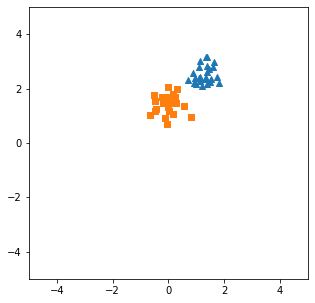

In [55]:
plt.figure(figsize=(5,5))
plt.scatter(shapes[0][0][:,0],shapes[0][0][:,1],marker='^')
plt.scatter(shapes[27][0][:,0],shapes[27][0][:,1],marker='s')
plt.xlim([-5,5])
plt.ylim([-5,5])
#plt.axis('equal')

In [17]:
points_in_shape = shapes[0][0].shape[0]
data = torch.zeros((len(shapes),points_in_shape*2+1))
for i,shape in enumerate(shapes):
    data[i,:]=torch.hstack([torch.tensor(shape[0].flatten()),torch.tensor(shape[1])])

In [18]:
data.shape

torch.Size([200, 51])

In [19]:
data[0]

tensor([1.3289, 2.3822, 1.3856, 2.8351, 1.2112, 2.0983, 1.1308, 2.4134, 0.8900,
        2.5605, 1.1043, 2.8037, 1.8035, 2.2043, 1.3793, 3.1443, 1.2948, 2.3534,
        0.9709, 2.1837, 1.1359, 2.2935, 1.0989, 2.4001, 1.6337, 2.9769, 1.3730,
        2.1736, 1.4994, 2.2523, 1.3718, 2.6078, 0.7179, 2.2989, 1.1485, 3.0289,
        1.7284, 2.4279, 1.4422, 2.7184, 0.9665, 2.4009, 1.5988, 2.7811, 1.5332,
        2.3682, 0.9041, 2.1998, 1.3465, 3.1517, 1.0000])

---
${ \bf Invariance}$ $f(Tx) = f(x)$: nodes $i,j$, $i<j$, 
$$| \vec{x}_i - \vec{x}_j |$$
Show this is conserved under $x_i \to Qx_i + g$,
$$| [Q_{ki}x_i +g] - [Q_{ij}x_j+g] |$$
$$=  | [Qx_i +g] - [Qx_j+g] |$$
$$= | Q(x_i - x_j) |$$
$$=  (x_i - x_j)^TQ^T Q(x_i - x_j) $$ 
$$= (x_i - x_j)^T \mathbb{I} (x_i - x_j), \quad \text{Q orthogonal matrix}$$
$$=| x_i - x_j |$$

My conception: Can only be used as input/additional feature, but not transmitted through the network well once we change the vectors to a norm.

---
${\bf Equivariance}$  $f(Tx) = T'f(x)$ for $T \cong T'$: nodes $i,j$, $i<j$,
$$\vec{f}(\vec{x}_i,\vec{x}_j)\equiv \mathbb{R}^2 \times \mathbb{R}^2 \to \mathbb{R}^2: x_i + C(x_i-x_j)$$
where $C$ is a scalar. Show when $x_i \to Qx_i + g$, this is equal to $Q\left(x_i + C(x_i-x_j) \right) + g$,
$$ [Q_{ki}x_i +g] + C([Q_{ki}x_i +g]-[Q_{ij}x_j+g]) $$
$$= [Qx_i +g] + C([Qx_i +g]-[Qx_j+g])$$
$$= [Qx_i +g] + Q C(x_i-x_j)$$
$$= Q\left( x_i + C(x_i-x_j) \right) +g$$

My conception: Can use this at any point in training beause the new output vectors can continue to be manipulated in this way, as e.g. in a linear layer, $x^{l+1} = Wx^l + b$, and the network remains equivariant using the above function consecutively.

---

In [70]:
# Define model
class classify_shapes(nn.Module):
    def __init__(self,n_samples,n_dim):
        super(classify_shapes,self).__init__() 
       
        self.network = nn.Sequential( nn.Linear(in_features = n_dim, out_features = n_dim, bias = True),
                                       nn.ReLU(),
                                       nn.Linear(in_features = n_dim, out_features = n_dim, bias = True),
                                       nn.ReLU(),
                                       nn.Linear(in_features = n_dim, out_features = 2, bias = True) )

#         self.make_between_01 = nn.Sigmoid()
        self.rescale = nn.Softmax(dim=1)
        self.n_samples = n_samples
        self.n_dim = n_dim

    def forward(self, x):
        classification = self.network(x).reshape(x.shape[0],2)
        #classification = self.make_between_01(x)
        classification = self.rescale(classification)
        return classification

In [71]:
def train(data,
          labels,
          model, 
          loss_fn, 
          epochs, 
          optimizer):
    
    history = {'train_loss': []} 
    
    best_val_loss = torch.inf
    start = time()
    
    data = data.to(device)
    labels = labels.to(device)
    x = data
    y = labels.type(torch.LongTensor)
    size = x.shape[0]
    
    for i in range(epochs):
        train_loss = 0.
        model.train()
        predictions = model(x) 
        loss = loss_fn(predictions,y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = loss.item()

        history['train_loss'].append(train_loss)
        
        if i%10==0:
            print(f"Epoch {i+1}   |  Train Loss: {train_loss}")
        if (i+1)==epochs:
            print(f"Epoch {i+1}   |  Train Loss: {train_loss}")
    
#         if train_loss*1e25 < 1:
#             print()
#             print('Reached Near Machine Zero')
#             break
        
        if train_loss < best_val_loss:
            best_val_loss = train_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            #torch.save(model.state_dict(),'simple_equivariant.pth')
    
    end = time()
    total_time = end-start
    print(f'Total Time: {total_time:>.8f}')
    return {'history': history}

In [22]:
loss = nn.CrossEntropyLoss()

In [23]:
torch.empty(3, dtype=torch.long).random_(5)

tensor([1, 1, 3])

In [24]:
probs = torch.tensor([[1.,0.,0.,0.,0.],
                      [0.,1.,0.,0.,0.],
                      [0.,0.,1.,0.,0.]]).reshape(3,5)

In [25]:
loss(probs,torch.tensor([0,1,2]))

tensor(0.9048)

---
## Traditional Network: Send in Raw Coordinates of Points

Using coordinates of nodes $x_i$ as features.

## Set Hyperparameters and Train the Model

In [72]:
torch.manual_seed(0)
n_samples  = data.shape[0] # sample size
n_dim      = int(data.shape[1]-1)   # dimension = coordinate points*2 - label column

data_train = copy.deepcopy(data[:,:n_dim])
labels_train = copy.deepcopy(data[:,n_dim])

lr = 1e-3
model = classify_shapes(n_samples,n_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [73]:
n_samples

200

In [74]:
n_dim

50

In [75]:
epochs = 100

training = train( data             = data_train,
                  labels           = labels_train,
                  model            = model, 
                  loss_fn          = loss_fn,
                  epochs           = epochs,
                  optimizer        = optimizer)

Epoch 1   |  Train Loss: 0.7046976913779605
Epoch 11   |  Train Loss: 0.6825777822209722
Epoch 21   |  Train Loss: 0.6639065058402115
Epoch 31   |  Train Loss: 0.6288806121838193
Epoch 41   |  Train Loss: 0.5758701259445843
Epoch 51   |  Train Loss: 0.5086836375916636
Epoch 61   |  Train Loss: 0.439349086248249
Epoch 71   |  Train Loss: 0.38365376482760266
Epoch 81   |  Train Loss: 0.3497240513791553
Epoch 91   |  Train Loss: 0.33276091545218506
Epoch 100   |  Train Loss: 0.3251049833621728
Total Time: 0.39429688


In [76]:
#model.load_state_dict(torch.load('best_SO4.pth',map_location=torch.device('cpu')))

## Visualize the History of Training Loss

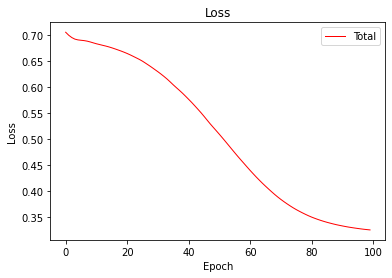

In [77]:
train_loss = np.array(training['history']['train_loss'])
N=train_loss.shape[0]
plt.figure(figsize=(6,4)) #, dpi=100)
plt.plot(train_loss[:N], linewidth=1, linestyle='-',  color = 'r', label='Total')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.yscale('log')
plt.title('Loss')
plt.show()

## Extract Results

In [78]:
model.eval()

with torch.no_grad():
    classify_new_shapes = model(data[:,:int(data.shape[1]-1)])

In [79]:
classify_new_shapes[:5]

tensor([[1.0229e-03, 9.9898e-01],
        [7.0155e-04, 9.9930e-01],
        [9.9969e-01, 3.0525e-04],
        [4.4047e-04, 9.9956e-01],
        [1.2880e-02, 9.8712e-01]])

Accuracy of Traditional Network

In [80]:
(torch.argmax(classify_new_shapes,dim=1)==labels_train).sum()

tensor(200)

---
## Invariant Network

Using as features $| x_i - x_j |$ for nodes $i,j$ for $i<j$

My conception: Can only be used as input/additional feature, but not transmitted through the network well once we change the vectors to a norm.

In [33]:
points_in_shape = shapes[0][0].shape[0]
# data_train[0].reshape(points_in_shape,2)

In [86]:
points_in_shape

25

In [34]:
n_distances = int(points_in_shape*(points_in_shape-1)/2)
combinations = itertools.combinations(np.arange(start=0,stop=points_in_shape),r=2)
data_invariant = torch.zeros(data_train.shape[0],n_distances)
for i,shape in tqdm(enumerate(shapes)):
    shape_tensor = torch.tensor(copy.deepcopy(shape[0]))
    indx = 0
    for two_points in itertools.combinations(np.arange(start=0,stop=points_in_shape),r=2):
        fst_indx = two_points[0]
        scd_indx = two_points[1]
        data_invariant[i,indx] = ((shape_tensor[fst_indx,:]-shape_tensor[scd_indx,:])**2).sum().sqrt()
        indx+=1

200it [00:02, 85.66it/s] 


In [81]:
data_invariant.shape

torch.Size([200, 300])

Plot distributions for three diffeent shapes of the invariant lengths

(array([4.000000, 7.000000, 6.000000, 8.000000, 14.000000, 15.000000,
        11.000000, 20.000000, 25.000000, 21.000000, 25.000000, 15.000000,
        12.000000, 20.000000, 12.000000, 14.000000, 8.000000, 12.000000,
        9.000000, 12.000000, 14.000000, 5.000000, 0.000000, 2.000000,
        5.000000, 2.000000, 0.000000, 0.000000, 0.000000, 2.000000]),
 array([0.007094, 0.054065, 0.101037, 0.148008, 0.194979, 0.241950,
        0.288922, 0.335893, 0.382864, 0.429835, 0.476806, 0.523778,
        0.570749, 0.617720, 0.664691, 0.711663, 0.758634, 0.805605,
        0.852576, 0.899548, 0.946519, 0.993490, 1.040461, 1.087432,
        1.134404, 1.181375, 1.228346, 1.275317, 1.322289, 1.369260,
        1.416231]),
 <BarContainer object of 30 artists>)

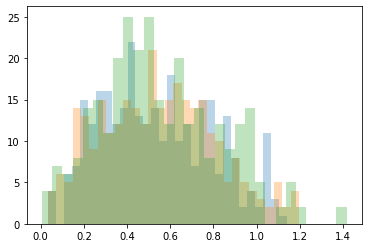

In [97]:
plt.hist(data_invariant[0,:],bins=30,alpha=0.3)
plt.hist(data_invariant[1,:],bins=30,alpha=0.3)
plt.hist(data_invariant[2,:],bins=30,alpha=0.3)

In [98]:
labels_train[2]

tensor(0.)

In [106]:
torch.max(data_invariant[labels_train==1.],dim=1).values.shape

torch.Size([100])

Plot max distance between points in shapes (square and triangle distributions)

(array([2.000000, 4.000000, 0.000000, 1.000000, 2.000000, 1.000000,
        5.000000, 4.000000, 8.000000, 6.000000, 5.000000, 5.000000,
        6.000000, 6.000000, 9.000000, 7.000000, 2.000000, 5.000000,
        4.000000, 1.000000, 2.000000, 2.000000, 1.000000, 3.000000,
        1.000000, 3.000000, 2.000000, 1.000000, 0.000000, 2.000000]),
 array([1.115624, 1.134080, 1.152535, 1.170991, 1.189446, 1.207902,
        1.226357, 1.244812, 1.263268, 1.281723, 1.300179, 1.318634,
        1.337090, 1.355545, 1.374001, 1.392456, 1.410912, 1.429367,
        1.447822, 1.466278, 1.484733, 1.503189, 1.521644, 1.540100,
        1.558555, 1.577011, 1.595466, 1.613922, 1.632377, 1.650832,
        1.669288]),
 <BarContainer object of 30 artists>)

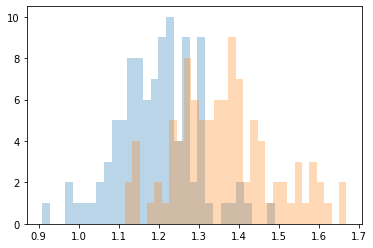

In [108]:
plt.hist(torch.max(data_invariant[labels_train==1.],dim=1).values,bins=30,alpha=0.3)
plt.hist(torch.max(data_invariant[labels_train==0.],dim=1).values,bins=30,alpha=0.3)

## Invariant: Set Hyperparameters and Train the Model

In [87]:
torch.manual_seed(0)
n_samples  = data.shape[0] # sample size, same as before
n_dim      = data_invariant.shape[1]   # dimension = coordinate points*2 - label column

data_train_inv = copy.deepcopy(data_invariant)
#labels_train = copy.deepcopy(data[:,n_dim]) # same as before

lr = 1e-3
model = classify_shapes(n_samples,n_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [88]:
epochs = 15

training = train( data             = data_train_inv,
                  labels           = labels_train,
                  model            = model, 
                  loss_fn          = loss_fn,
                  epochs           = epochs,
                  optimizer        = optimizer)

Epoch 1   |  Train Loss: 0.6970955544856551
Epoch 11   |  Train Loss: 0.32345336537731484
Epoch 15   |  Train Loss: 0.31384501474757603
Total Time: 0.34540606


In [43]:
#model.load_state_dict(torch.load('best_SO4.pth',map_location=torch.device('cpu')))

## Invariant: Visualize the History of Training Loss

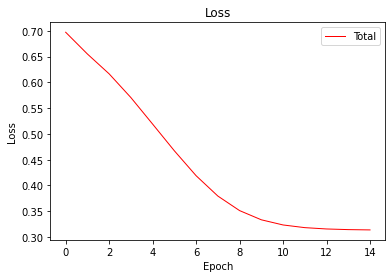

In [89]:
train_loss = np.array(training['history']['train_loss'])
N=train_loss.shape[0]
plt.figure(figsize=(6,4)) #, dpi=100)
plt.plot(train_loss[:N], linewidth=1, linestyle='-',  color = 'r', label='Total')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.yscale('log')
plt.title('Loss')
plt.show()

## Invariant: Extract Results

In [90]:
model.eval()

with torch.no_grad():
    classify_new_shapes = model(data_train_inv)

In [91]:
classify_new_shapes[:5]

tensor([[3.8140e-04, 9.9962e-01],
        [3.0754e-04, 9.9969e-01],
        [9.9946e-01, 5.3912e-04],
        [2.3214e-04, 9.9977e-01],
        [3.9198e-05, 9.9996e-01]])

Accuracy

In [92]:
(torch.argmax(classify_new_shapes,dim=1)==labels_train).sum()

tensor(200)

---
## Equivariant Network

Using $x_i + C(x_i-x_j)$ as features, where $C$ is a scalar.

My conception: Can use this at any point in training beause the new output vectors can continue to be manipulated in this way, as e.g. in a linear layer, $x^{l+1} = Wx^l + b$, and the network remains equivariant using the above function consecutively.

In [112]:
points_in_shape = shapes[0][0].shape[0]
# data_train[0].reshape(points_in_shape,2)

In [113]:
C=1
n_distances = int(points_in_shape*(points_in_shape-1)/2)
combinations = itertools.combinations(np.arange(start=0,stop=points_in_shape),r=2)
data_equivariant = torch.zeros(data_train.shape[0],n_distances*2)
for i,shape in tqdm(enumerate(shapes)):
    shape_tensor = torch.tensor(copy.deepcopy(shape[0]))
    indx = 0
    for two_points in itertools.combinations(np.arange(start=0,stop=points_in_shape),r=2):
        fst_indx = two_points[0]
        scd_indx = two_points[1]
        data_equivariant[i,indx:int(indx+2)] = (shape_tensor[fst_indx,:]+C*(shape_tensor[fst_indx,:]-shape_tensor[scd_indx,:]))
        indx+=2

200it [00:03, 61.64it/s]


In [114]:
data_equivariant.shape

torch.Size([200, 600])

In [115]:
data_equivariant[0,:2]

tensor([1.2722, 1.9293])

In [116]:
test_check = data_train[0].reshape(points_in_shape,2)

In [117]:
# test_check

In [118]:
(test_check[0,:]+C*(test_check[0,:]-test_check[1,:]))

tensor([1.2722, 1.9293])

In [119]:
data_equivariant[1,0]

tensor(2.7155)

## Equivariant: Set Hyperparameters and Train the Model

In [120]:
torch.manual_seed(0)
n_samples  = data.shape[0] # sample size, same as before
n_dim      = data_equivariant.shape[1]   # dimension = coordinate points*2 - label column

data_train_equi = copy.deepcopy(data_equivariant)
# labels_train = copy.deepcopy(data[:,n_dim]) # same as before

lr = 1e-3
model = classify_shapes(n_samples,n_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [121]:
epochs = 15

training = train( data             = data_train_equi,
                  labels           = labels_train,
                  model            = model, 
                  loss_fn          = loss_fn,
                  epochs           = epochs,
                  optimizer        = optimizer)

Epoch 1   |  Train Loss: 0.6979627015745483
Epoch 11   |  Train Loss: 0.33129550268261104
Epoch 15   |  Train Loss: 0.3179768046797371
Total Time: 0.53044510


In [122]:
#model.load_state_dict(torch.load('best_SO4.pth',map_location=torch.device('cpu')))

## Equivariant: Visualize the History of Training Loss

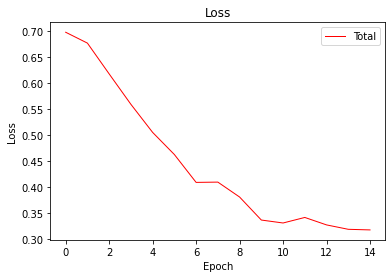

In [123]:
train_loss = np.array(training['history']['train_loss'])
N=train_loss.shape[0]
plt.figure(figsize=(6,4)) #, dpi=100)
plt.plot(train_loss[:N], linewidth=1, linestyle='-',  color = 'r', label='Total')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.yscale('log')
plt.title('Loss')
plt.show()

## Equivariant: Extract Results

In [124]:
model.eval()

with torch.no_grad():
    classify_new_shapes = model(data_train_equi)

In [125]:
classify_new_shapes[:5]

tensor([[1.2234e-04, 9.9988e-01],
        [6.5383e-04, 9.9935e-01],
        [9.9998e-01, 2.3215e-05],
        [2.8661e-05, 9.9997e-01],
        [1.2416e-04, 9.9988e-01]])

Accuracy

In [126]:
(torch.argmax(classify_new_shapes,dim=1)==labels_train).sum()

tensor(200)

In [102]:
# Trying to determine minimum loss possible
(-np.log(np.max(classify_new_shapes.detach().numpy(),axis=0))).sum()

8.717247514467548e-06